In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from pandas import DataFrame
from pandas import Grouper
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

In [2]:
# data imported
data=pd.read_csv('Book1.csv',header=0, index_col=0, parse_dates=True)

# EDA & Preprocessing

In [6]:
#shape
data.shape

(42, 1)

In [7]:
data.head()

,inflation_rate
year,
1980-01-01,11.346
1981-01-01,12.654
1982-01-01,7.736
1983-01-01,12.558
1984-01-01,6.517


# Upsampling data Yearly to Monthly

In [8]:
upsampled = data.resample('M').mean()
print(upsampled.head(24))

            inflation_rate
year                      
1980-01-31          11.346
1980-02-29             NaN
1980-03-31             NaN
1980-04-30             NaN
1980-05-31             NaN
1980-06-30             NaN
1980-07-31             NaN
1980-08-31             NaN
1980-09-30             NaN
1980-10-31             NaN
1980-11-30             NaN
1980-12-31             NaN
1981-01-31          12.654
1981-02-28             NaN
1981-03-31             NaN
1981-04-30             NaN
1981-05-31             NaN
1981-06-30             NaN
1981-07-31             NaN
1981-08-31             NaN
1981-09-30             NaN
1981-10-31             NaN
1981-11-30             NaN
1981-12-31             NaN


In [9]:
# interplote null value
interpolated = upsampled.interpolate(method='linear')
print(interpolated.head(24))


            inflation_rate
year                      
1980-01-31       11.346000
1980-02-29       11.455000
1980-03-31       11.564000
1980-04-30       11.673000
1980-05-31       11.782000
1980-06-30       11.891000
1980-07-31       12.000000
1980-08-31       12.109000
1980-09-30       12.218000
1980-10-31       12.327000
1980-11-30       12.436000
1980-12-31       12.545000
1981-01-31       12.654000
1981-02-28       12.244167
1981-03-31       11.834333
1981-04-30       11.424500
1981-05-31       11.014667
1981-06-30       10.604833
1981-07-31       10.195000
1981-08-31        9.785167
1981-09-30        9.375333
1981-10-31        8.965500
1981-11-30        8.555667
1981-12-31        8.145833


In [10]:
# export new montly data file
interpolated.to_csv('Inflation Rate  (montly).csv',index=True)

In [11]:
interpolated.describe()

,inflation_rate
count,493.000000
mean,7.615614
std,2.762229
min,3.428000
25%,4.977250
50%,7.675250
75%,9.833333
max,13.483000


In [12]:
# checking null values
interpolated.isnull().sum()

inflation_rate    0
dtype: int64

In [13]:
# getting information
interpolated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 493 entries, 1980-01-31 to 2021-01-31
Freq: M
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   inflation_rate  493 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB


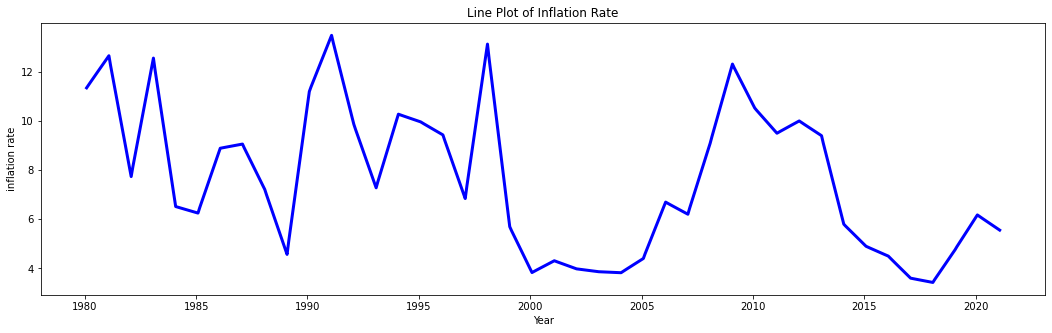

In [14]:
# line plot
plt.figure(figsize=(18,5))
plt.plot(interpolated['inflation_rate'], color = 'blue', linewidth=3)
plt.xlabel('Year')
plt.ylabel('inflation rate')
plt.title ("Line Plot of Inflation Rate")
plt.show()

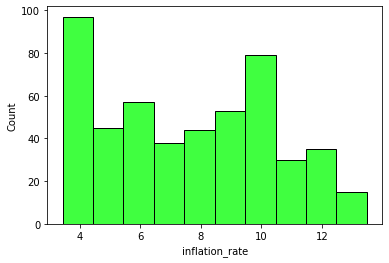

In [15]:
# histplot
sns.histplot(data=interpolated, x="inflation_rate", color="lime")
plt.show()

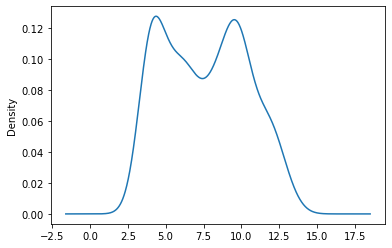

In [16]:
# Distplot
interpolated.inflation_rate.plot(kind='kde')
plt.show()

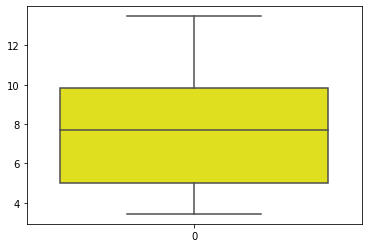

In [17]:
# boxplot
sns.boxplot(data=interpolated['inflation_rate'],color='yellow')
plt.show()

<Figure size 1296x360 with 0 Axes>

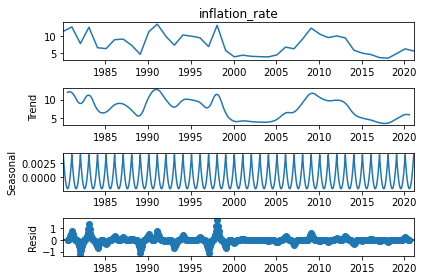

In [18]:
# seasonal decompose graph
plt.figure(figsize=(18,5))
decompose_ts_add = seasonal_decompose(interpolated.inflation_rate,period=12)
decompose_ts_add.plot()
plt.show()

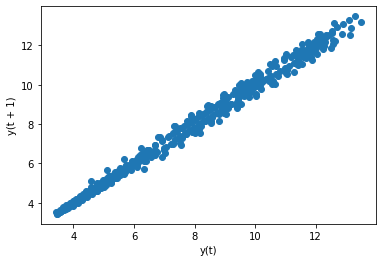

In [19]:
# 1step lag graph
lag_plot(interpolated.inflation_rate)
plt.show()

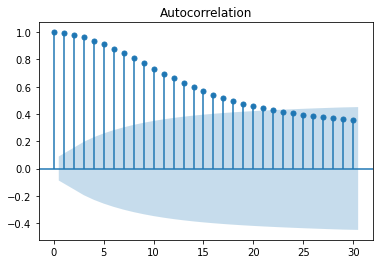

In [20]:
# auto corelation plot
plot_acf(interpolated.inflation_rate,lags=30)
plt.show()

In [21]:
data=pd.read_csv('Inflation Rate  (montly).csv',header=0)
data

,year,inflation_rate
0,1980-01-31,11.3460
1,1980-02-29,11.4550
2,1980-03-31,11.5640
3,1980-04-30,11.6730
4,1980-05-31,11.7820
...,...,...
488,2020-09-30,5.7630
489,2020-10-31,5.7115
490,2020-11-30,5.6600
491,2020-12-31,5.6085


In [22]:
# creating some features for model based approach
data['t']=np.arange(1,(len(data)+1))
data['t_square']=data['t']*data['t']
data['log_rate']=np.log(data['inflation_rate'])
data['year_'] = pd.to_datetime(data['year']).dt.year
data['month'] = pd.to_datetime(data['year']).dt.month_name()


In [23]:
data.head()

,year,inflation_rate,t,t_square,log_rate,year_,month
0,1980-01-31,11.346,1,1,2.428865,1980,January
1,1980-02-29,11.455,2,4,2.438426,1980,February
2,1980-03-31,11.564,3,9,2.447897,1980,March
3,1980-04-30,11.673,4,16,2.457278,1980,April
4,1980-05-31,11.782,5,25,2.466573,1980,May


<AxesSubplot:xlabel='month', ylabel='year_'>

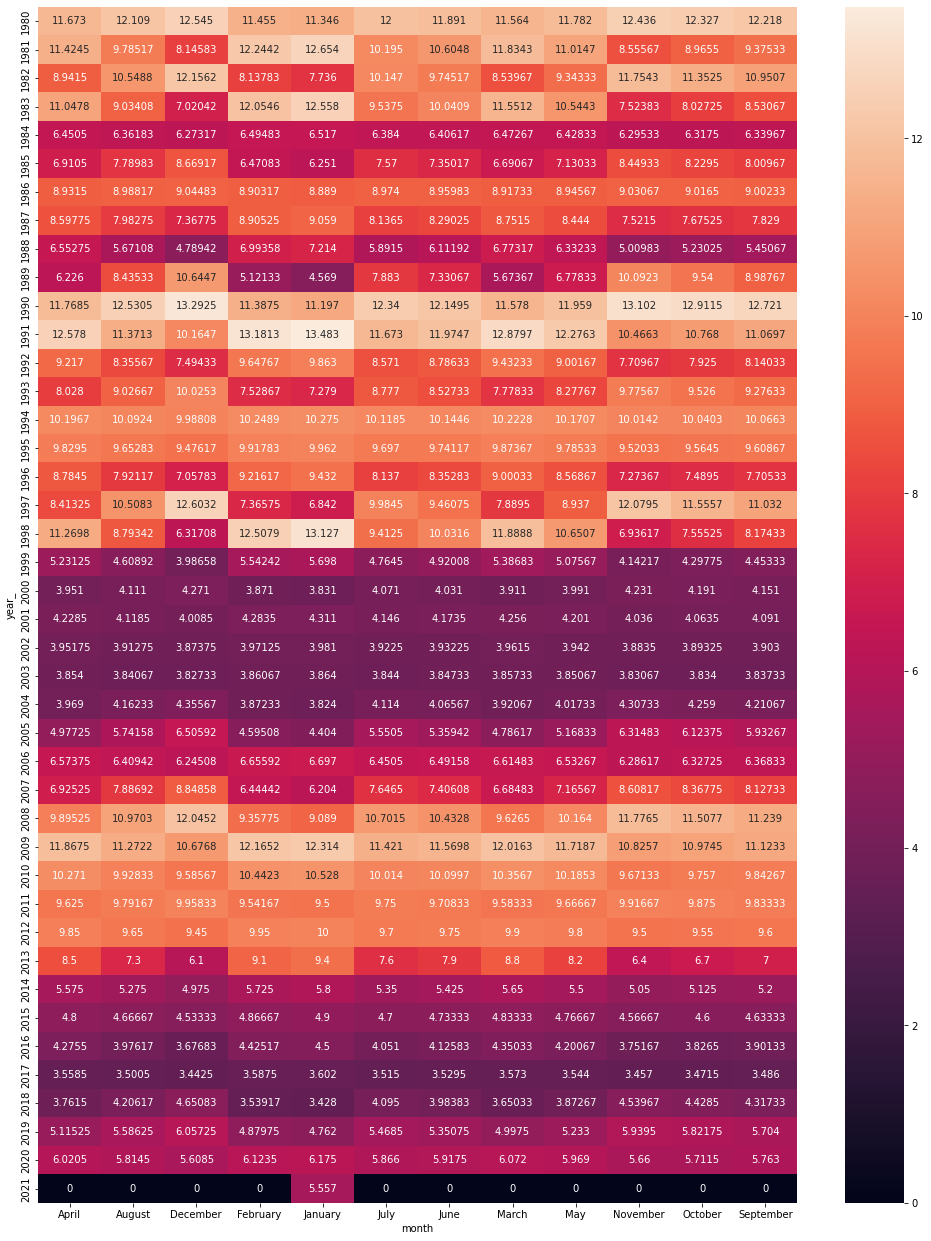

In [24]:
# heat map of month and year
plt.figure(figsize=(17,22))
heatmap_y_month = pd.pivot_table(data=data,values="inflation_rate",index="year_",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") 

In [25]:
df=pd.get_dummies(data.month)

In [26]:
data_1=data.join(df)

In [27]:
data_1

,year,inflation_rate,t,t_square,log_rate,year_,month,April,August,December,February,January,July,June,March,May,November,October,September
0,1980-01-31,11.3460,1,1,2.428865,1980,January,0,0,0,0,1,0,0,0,0,0,0,0
1,1980-02-29,11.4550,2,4,2.438426,1980,February,0,0,0,1,0,0,0,0,0,0,0,0
2,1980-03-31,11.5640,3,9,2.447897,1980,March,0,0,0,0,0,0,0,1,0,0,0,0
3,1980-04-30,11.6730,4,16,2.457278,1980,April,1,0,0,0,0,0,0,0,0,0,0,0
4,1980-05-31,11.7820,5,25,2.466573,1980,May,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2020-09-30,5.7630,489,239121,1.751458,2020,September,0,0,0,0,0,0,0,0,0,0,0,1
489,2020-10-31,5.7115,490,240100,1.742482,2020,October,0,0,0,0,0,0,0,0,0,0,1,0
490,2020-11-30,5.6600,491,241081,1.733424,2020,November,0,0,0,0,0,0,0,0,0,1,0,0
491,2020-12-31,5.6085,492,242064,1.724283,2020,December,0,0,1,0,0,0,0,0,0,0,0,0


# MODEL BASED METHODS

# LINEAR MODEL

In [28]:
Train = data_1.head(345)
Test = data_1.tail(148)

In [29]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

In [30]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('inflation_rate~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['inflation_rate'], pred_linear)
rmse_linear_model

3.2932377028322417

# Exponential Model

In [31]:
Exp = smf.ols('log_rate~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_exp = RMSE(Test['inflation_rate'], np.exp(pred_Exp))
rmse_exp

3.368273583683409

# Quadratic Model

In [32]:
Quad = smf.ols('inflation_rate~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_quad_model = RMSE(Test['inflation_rate'], pred_Quad)
rmse_quad_model

3.2685560916757828

# Additive Seasonality model

In [33]:
add_sea = smf.ols('inflation_rate~January+February+March+April+May+June+July+August+September+October+November',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['January','February','March','April','May','June','July','August','September','October','November']]))
rmse_add_sea = RMSE(Test['inflation_rate'], pred_add_sea)
rmse_add_sea

2.9353126336421056

# Additive Seasonality Quadratic model

In [34]:
add_sea_Quad = smf.ols('inflation_rate~t+t_square+January+February+March+April+May+June+July+August+September+October+November',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['January','February','March','April','May','June','July','August','September','October','November','t','t_square']]))
rmse_add_sea_quad = RMSE(Test['inflation_rate'], pred_add_sea_quad)
rmse_add_sea_quad    

3.279261063348883

# Multiplicative Seasonality model

In [35]:
Mul_sea = smf.ols('log_rate~January+February+March+April+May+June+July+August+September+October+November',data=Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mul_sea = RMSE(Test['inflation_rate'], np.exp(pred_Mult_sea))
rmse_Mul_sea

2.804364304962696

# Multiplicative Addictive Seasonality Model

In [36]:
Mul_Add_sea = smf.ols('log_rate~t+January+February+March+April+May+June+July+August+September+October+November',data = Train).fit()
pred_Mul_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mul_add_sea = RMSE(Test['inflation_rate'], np.exp(pred_Mul_add_sea))
rmse_Mul_add_sea

3.373431473318601

# DATA DRIVEN METHODS

In [37]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# Simple Exponential Method

In [54]:
ses_model = SimpleExpSmoothing(Train["inflation_rate"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = RMSE(Test.inflation_rate, pred_ses)
rmse_ses

4.288231795223578

# Holt Method

In [55]:
hw_model = Holt(Train["inflation_rate"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = RMSE(Test.inflation_rate, pred_hw)
rmse_hw

28.028149254370774

# Holts winter exponential smoothing with additive seasonality and additive trend

In [40]:
hwe_model_add_add = ExponentialSmoothing(Train["inflation_rate"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add = RMSE(Test.inflation_rate, pred_hwe_add_add)
rmse_hwe_add_add

28.08600485568644

# Holts winter exponential smoothing with additive multiplicative and additive trend

In [41]:
hwe_model_mul_add = ExponentialSmoothing(Train["inflation_rate"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_mul_add = RMSE(Test.inflation_rate, pred_hwe_mul_add)
rmse_hwe_mul_add

25.703225719361967

# P D Q ORDER FOR ARIMA MODEL

In [151]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True, squeeze=True,)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=3.694
ARIMA(0, 0, 1) RMSE=1.853
ARIMA(0, 0, 2) RMSE=0.993
ARIMA(0, 1, 0) RMSE=0.145
ARIMA(0, 1, 1) RMSE=0.091
ARIMA(0, 1, 2) RMSE=0.075
ARIMA(0, 2, 0) RMSE=0.060
ARIMA(0, 2, 1) RMSE=0.060
ARIMA(0, 2, 2) RMSE=0.060
ARIMA(1, 0, 0) RMSE=0.147
ARIMA(1, 0, 1) RMSE=0.093
ARIMA(1, 0, 2) RMSE=0.078
ARIMA(1, 1, 0) RMSE=0.056
ARIMA(1, 1, 1) RMSE=0.056
ARIMA(1, 1, 2) RMSE=0.056
ARIMA(1, 2, 0) RMSE=0.060
ARIMA(1, 2, 1) RMSE=0.060
ARIMA(1, 2, 2) RMSE=0.057
ARIMA(2, 0, 0) RMSE=0.073
ARIMA(2, 0, 1) RMSE=0.073
ARIMA(2, 0, 2) RMSE=0.074
ARIMA(2, 1, 0) RMSE=0.056
ARIMA(2, 1, 1) RMSE=0.065
ARIMA(2, 1, 2) RMSE=0.066
ARIMA(2, 2, 0) RMSE=0.060
ARIMA(2, 2, 1) RMSE=0.060
ARIMA(2, 2, 2) RMSE=0.059
ARIMA(4, 0, 0) RMSE=0.073
ARIMA(4, 0, 1) RMSE=0.074
ARIMA(4, 0, 2) RMSE=0.074
ARIMA(4, 1, 0) RMSE=0.057
ARIMA(4, 1, 1) RMSE=0.065
ARIMA(4, 1, 2) RMSE=0.066
ARIMA(4, 2, 0) RMSE=0.060
ARIMA(4, 2, 1) RMSE=0.060
ARIMA(4, 2, 2) RMSE=0.060
ARIMA(6, 0, 0) RMSE=0.073
ARIMA(6, 0, 1) RMSE=0.073
ARIMA(6, 0, 

# RMSE SCORES FOR ALL MODELS

In [64]:
data = pd.read_csv('Inflation Rate  (montly).csv', header=0, index_col=0, parse_dates=True)

In [65]:
# separate out a validation dataset
split_point = len(data) - 148
dataset, validation = data[0:split_point], data[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 345, Validation 148


In [71]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [72]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=10.197, Expected=10.171
>Predicted=10.171, Expected=10.145
>Predicted=10.145, Expected=10.118
>Predicted=10.118, Expected=10.092
>Predicted=10.092, Expected=10.066
>Predicted=10.066, Expected=10.040
>Predicted=10.040, Expected=10.014
>Predicted=10.014, Expected=9.988
>Predicted=9.988, Expected=9.962
>Predicted=9.962, Expected=9.918
>Predicted=9.918, Expected=9.874
>Predicted=9.874, Expected=9.830
>Predicted=9.830, Expected=9.785
>Predicted=9.785, Expected=9.741
>Predicted=9.741, Expected=9.697
>Predicted=9.697, Expected=9.653
>Predicted=9.653, Expected=9.609
>Predicted=9.609, Expected=9.564
>Predicted=9.564, Expected=9.520
>Predicted=9.520, Expected=9.476
>Predicted=9.476, Expected=9.432
>Predicted=9.432, Expected=9.216
>Predicted=9.216, Expected=9.000
>Predicted=9.000, Expected=8.785
>Predicted=8.785, Expected=8.569
>Predicted=8.569, Expected=8.353
>Predicted=8.353, Expected=8.137
>Predicted=8.137, Expected=7.921
>Predicted=7.921, Expected=7.705
>Predicted=7.705, Expected=7

In [73]:
train1=pd.read_csv('dataset.csv',header=0, index_col=0, parse_dates=True)
train1.head(5)

,11.346
1980-01-31,
1980-02-29,11.455
1980-03-31,11.564
1980-04-30,11.673
1980-05-31,11.782
1980-06-30,11.891


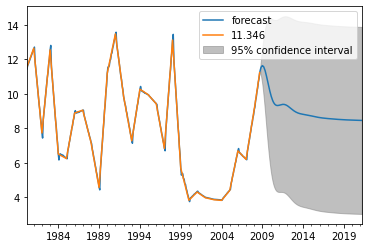

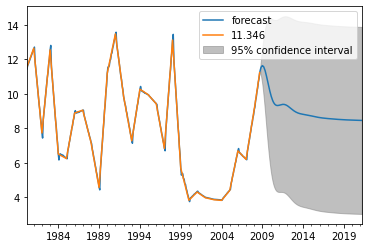

In [74]:
# fit model
model = ARIMA(train1, order=(10,0,2))
model_fit = model.fit()
forecast=model_fit.forecast(steps=148)[0]
model_fit.plot_predict(1, 493)

In [75]:
val=pd.read_csv('validation.csv',header=None)
Arima_rmse = sqrt(mean_squared_error(val[1], forecast))
Arima_rmse

3.0340871822218896

In [59]:
# FIT MODEL ON P D Q ORDER CALCULATED
data = read_csv('Inflation Rate  (montly).csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = data.values
X = X.astype('float32')

In [60]:
model = ARIMA(X, order=(10,0,2))
model_fit = model.fit()

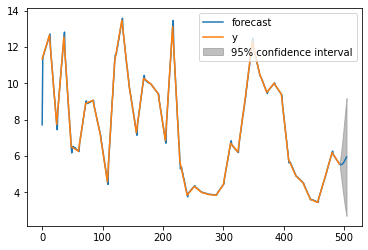

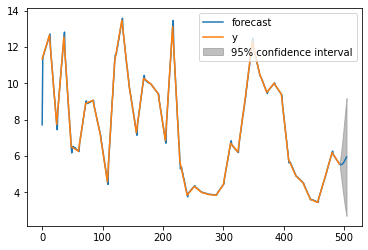

In [61]:
forecast=model_fit.forecast(steps=11)[0]
model_fit.plot_predict(0,504)

In [76]:
list = [['Simple Exponential Method',rmse_ses], ['Holt method',rmse_hw],
          ['HW exp smoothing add',rmse_hwe_add_add],['HW exp smoothing mult',rmse_hwe_mul_add],
          ['Linear ModeL',rmse_linear_model],['Exp model',rmse_exp],['Quad model',rmse_quad_model],
          ['add seasonality',rmse_add_sea],['Quad add seasonality',rmse_add_sea_quad],
          ['Mult Seasonality',rmse_Mul_sea],['Mult add seasonality',rmse_Mul_add_sea],['ARIMA_MODEL',Arima_rmse]]

In [77]:
df = pd.DataFrame(list, columns =['Model', 'RMSE_Value']) 
df.sort_values(['RMSE_Value'])

,Model,RMSE_Value
9,Mult Seasonality,2.804364
7,add seasonality,2.935313
11,ARIMA_MODEL,3.034087
6,Quad model,3.268556
8,Quad add seasonality,3.279261
4,Linear ModeL,3.293238
5,Exp model,3.368274
10,Mult add seasonality,3.373431
0,Simple Exponential Method,4.288232
3,HW exp smoothing mult,25.703226
